In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file = "./Datasets/forecasting.csv"
df = pd.read_csv(file)
df.head()

,admin2,province_state,country_region,fips,latitude,longitude,date,cases,death,source,update_date
0,NaN,NaN,US,NaN,37.0902,-95.7129,1/21/2020,1,0,https://github.com/nytimes/covid-19-data,3/28/2020
1,NaN,NaN,US,NaN,37.0902,-95.7129,1/22/2020,1,0,https://github.com/nytimes/covid-19-data,3/28/2020
2,NaN,NaN,US,NaN,37.0902,-95.7129,1/23/2020,1,0,https://github.com/nytimes/covid-19-data,3/28/2020
3,NaN,NaN,US,NaN,37.0902,-95.7129,1/24/2020,2,0,https://github.com/nytimes/covid-19-data,3/28/2020
4,NaN,NaN,US,NaN,37.0902,-95.7129,1/25/2020,3,0,https://github.com/nytimes/covid-19-data,3/28/2020


In [3]:
df = df.loc[(df["country_region"] == "US")]
df

,admin2,province_state,country_region,fips,latitude,longitude,date,cases,death,source,update_date
0,NaN,NaN,US,NaN,37.0902,-95.7129,1/21/2020,1,0,https://github.com/nytimes/covid-19-data,3/28/2020
1,NaN,NaN,US,NaN,37.0902,-95.7129,1/22/2020,1,0,https://github.com/nytimes/covid-19-data,3/28/2020
2,NaN,NaN,US,NaN,37.0902,-95.7129,1/23/2020,1,0,https://github.com/nytimes/covid-19-data,3/28/2020
3,NaN,NaN,US,NaN,37.0902,-95.7129,1/24/2020,2,0,https://github.com/nytimes/covid-19-data,3/28/2020
4,NaN,NaN,US,NaN,37.0902,-95.7129,1/25/2020,3,0,https://github.com/nytimes/covid-19-data,3/28/2020
...,...,...,...,...,...,...,...,...,...,...,...
4885,NaN,NaN,US,NaN,37.0902,-95.7129,3/29/2020,140886,2467,https://data.humdata.org/dataset/novel-coronav...,3/31/2020
5068,NaN,NaN,US,NaN,37.0902,-95.7129,3/30/2020,161807,2978,https://data.humdata.org/dataset/novel-coronav...,4/3/2020
5243,NaN,NaN,US,NaN,37.0902,-95.7129,3/31/2020,188172,3873,https://data.humdata.org/dataset/novel-coronav...,4/3/2020
5420,NaN,NaN,US,NaN,37.0902,-95.7129,4/1/2020,213372,4757,https://data.humdata.org/dataset/novel-coronav...,4/3/2020


In [4]:
df = df.loc[:,['date','cases']]
df

,date,cases
0,1/21/2020,1
1,1/22/2020,1
2,1/23/2020,1
3,1/24/2020,2
4,1/25/2020,3
...,...,...
4885,3/29/2020,140886
5068,3/30/2020,161807
5243,3/31/2020,188172
5420,4/1/2020,213372


In [5]:
FMT = '%m/%d/%Y'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("01/01/2020", FMT)).days)

In [6]:
df

,date,cases
0,20,1
1,21,1
2,22,1
3,23,2
4,24,3
...,...,...
4885,88,140886
5068,89,161807
5243,90,188172
5420,91,213372


## The logistic model
The logistic model has been widely used to describe the growth of a population. An infection can be described as the growth of the population of a pathogen agent, so a logistic model seems reasonable.
This formula is very known among data scientists because it’s used in the logistic regression classifier and as an activation function of neural networks.
The most generic expression of a logistic function is:
logistic_model(x,a,b,c) = c/(1+np.exp(-(x-b)/a))

In this formula, we have the variable x that is the time and three parameters: a,b,c.

#### a: refers to the infection speed
#### b: is the day with the maximum infections occurred
#### c: is the total number of recorded infected people at the infection’s end

At high time values, the number of infected people gets closer and closer to c and that’s the point at which we can say that the infection has ended. This function has also an inflection point at b, that is the point at which the first derivative starts to decrease (i.e. the peak after which the infection starts to become less aggressive and decreases).

In [7]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [11]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[20,1,300000])
print(fit)

(array([3.76377701e+00, 8.97720972e+01, 3.70769831e+05]), array([[3.96892612e-03, 1.23199041e-02, 5.66626282e+02],
       [1.23199041e-02, 4.45869719e-02, 2.07737937e+03],
       [5.66626282e+02, 2.07737937e+03, 9.81934029e+07]]))


Here are the values:

#### a: 3.76
#### b: 89.77
#### c: 370770

The function returns the covariance matrix too, whose diagonal values are the variances of the parameters. Taking their square root we can calculate the standard errors.

In [12]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
print(errors)

[0.06299941367490812, 0.2111562736272999, 9909.258442002947]


#### Standard error of a: 0.037
#### Standard error of b: 0.192
#### Standard error of c: 7027.66
These numbers give us many useful insights.
The expected number of infected people at infection end is 370770+/- 7027.66.

In [13]:
a = 3.76
b = 89.77
c = 370770

The expected infection end can be calculated as that particular day at which the cumulative infected people count is equal to the c parameter rounded to the nearest integer.

We can use the fsolve function of scipy to numerically find the root of the equation that defines the infection end day.

In [14]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
print(sol)

228


#### The expected number of infected people at infection end is 370770+/- 7027.66.
#### The infection end day: It’s on August 16, 2020.

## Exponential model
While the logistic model describes ain infection growth that is going to stop in the future, The exponential model describes an unstoppable infection growth. For example, if a patient infects 2 patients per day, after 1 day we’ll have 2 infections, 4 after 2 days, 8 after 3 and so on.
The most generic exponential function is:
exponential_model(x,a,b,c) = a*np.exp(b*(x-c))
    
The variable x is the time and we still have the parameters a, b, c. The meaning, however, is different from the logistic function parameters’.
Let’s define the function in Python and let’s perform the same curve fitting procedure used for logistic growth.

In [36]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))
exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,30])
print(exp_fit)

(array([13.88833901,  0.17244749, 34.99036659]), array([[2.60738264e+15, 1.42677188e+05, 1.08867341e+15],
       [1.42677223e+05, 2.03123292e-05, 5.95727326e+04],
       [1.08867341e+15, 5.95727181e+04, 4.54559209e+14]]))


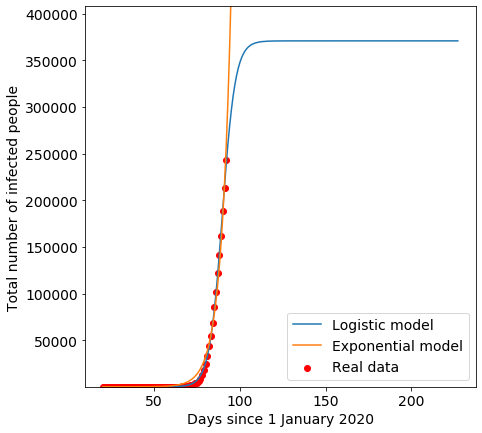

In [37]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

Both theoretical curves seem to approximate the experimental trend quite well. Which one does it better? Let’s take a look at the residuals.

## Analysis of residuals
Residuals are the differences between each experimental point and the corresponding theoretical point. We can analyze the residuals of both models in order to verify the best fitting curve. In a first approximation, the lower Mean Squared Error between theoretical and experimental data, the better the fit.

In [35]:
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x]
y_pred_exp =  [exponential_model(i,exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in x]
mean_squared_error(y,y_pred_logistic)
mean_squared_error(y,y_pred_exp)
print(mean_squared_error(y,y_pred_logistic))
print(mean_squared_error(y,y_pred_exp))

2102918.0103298877
22844615.406226028


## Which is the right model?
Residuals analysis seems to point toward the logistic model. It’s very likely because the infection should end someday in the future; even if everybody will be infected, they’ll develop the proper immunity defense to avoid a second infection. That’s right as long as the virus doesn’t mutate too much (as, for example, influenza virus).
But there’s something that still worries me. I’ve been fitting the logistic curve every day since the beginning of the infection and every day I got different parameter values. The number of infected people at the end increases, the maximum infection day is often the current day or the next day (which is compatible with the standard error of 1 day on this parameter). That’s why I think that, although the logistic model seems to be the most reasonable one, the shape of the curve will probably change due to exogenous effects like new infection hotspots, government actions to bind the infection and so on.
That’s why I think that the predictions of this model will start to become useful only within a few weeks, reasonably after the infection peak.